# Part 1: Setting up packages and loading in dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Part2: Feature Engineering

## Loading Data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Concatnate data together for Feature Engineering

In [4]:
data = pd.concat([train_data, test_data])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **Create new Variable: Title. Extract title from Name variable**

In [5]:
data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(data['Title'], data['Pclass'])

Pclass,1,2,3
Title,,,
Capt,1,0,0
Col,4,0,0
Countess,1,0,0
Don,1,0,0
Dona,1,0,0
Dr,6,2,0
Jonkheer,1,0,0
Lady,1,0,0
Major,2,0,0


## **Imputing**: Imputing Age column with median Age for each Title

In [6]:
age_title = data.groupby('Title').Age.median()
data = data.assign(
    Age = data.apply(lambda x: x.Age if pd.notnull(x.Age) else age_title[x.Title] , axis=1)
)
age_title

Title
Capt        70.0
Col         54.5
Countess    33.0
Don         40.0
Dona        39.0
Dr          49.0
Jonkheer    38.0
Lady        48.0
Major       48.5
Master       4.0
Miss        22.0
Mlle        24.0
Mme         24.0
Mr          29.0
Mrs         35.5
Ms          28.0
Rev         41.5
Sir         49.0
Name: Age, dtype: float64

## **Creating new variable: family. Calculate number of family** 

In [7]:
data['family_size'] = data['SibSp'] + data['Parch']
#test_data['family_size'] = test_data['SibSp'] + test_data['Parch']

data[['family_size','Survived']].groupby(['family_size']).agg(['count','mean'])

Survived          
               count      mean
family_size                   
0                537  0.303538
1                161  0.552795
2                102  0.578431
3                 29  0.724138
4                 15  0.200000
5                 22  0.136364
6                 12  0.333333
7                  6  0.000000
10                 7  0.000000

## **Creating new variable: IsAlone: Whether the person is onboard alone or not** 

In [8]:
data['IsAlone'] = (data['family_size'] == 0).astype(int)
data[['IsAlone', 'Survived']].groupby(['IsAlone']).agg(['count','mean'])

Survived          
           count      mean
IsAlone                   
0            354  0.505650
1            537  0.303538

## **Creating new variable: Age bands**

In [9]:
# Define the bin edges and labels
bins = [0, 10, 18, 35, 50, 70, 100]
labels = ['Child', 'Teenagers','Young Adult', 'Adult', 'Senior', 'Elderly']

# Create age bins
data['AgeBand'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False).astype(str)
data[['AgeBand', 'Survived']].groupby(['AgeBand']).agg(['count','mean'])



Survived          
               count      mean
AgeBand                       
Adult            179  0.452514
Child             66  0.606061
Elderly            7  0.142857
Senior            67  0.388060
Teenagers         51  0.450980
Young Adult      521  0.328215

## **Creating new variable: Fare bands**

In [10]:
bins = [0, 0.01, 7.5, 12.5, 17, 29, 75,150 ,600]
labels = ['Fare0', 'Fare1', 'Fare2', 'Fare3', 'Fare4', 'Fare5','Fare6','Fare7']

# Create age bins
data['FareBand'] = pd.cut(data['Fare'], bins=bins, labels=labels, right=False).astype(str)
data[['FareBand', 'Survived']].groupby(['FareBand']).agg(['count','mean'])


Survived          
            count      mean
FareBand                   
Fare0          15  0.066667
Fare1          72  0.152778
Fare2         296  0.260135
Fare3         113  0.380531
Fare4         145  0.455172
Fare5         153  0.457516
Fare6          68  0.794118
Fare7          29  0.689655
nan             0       NaN

## **Creating new variable: Replacing rare title with major ones to avoid overfitting**

In [11]:
data['Title'] = data['Title'].replace(['Don', 'Capt', 'Col', 'Major', 'Sir', 'Jonkheer', 'Rev', 'Dr'], 'Honored')
data['Title'] = data['Title'].replace(['Lady', 'Dona', 'Mme', 'Countess'], 'Mrs')
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data[['Title', 'Survived']].groupby(['Title']).agg(['count','mean'])

Survived          
           count      mean
Title                     
Honored       21  0.285714
Master        40  0.575000
Miss         185  0.702703
Mr           517  0.156673
Mrs          128  0.796875

## **Creating new variable: Replacing Cabin variable with first letter from Cabin variable**

In [12]:
data[data['Cabin'].isna()]
data['CabinCode'] = data['Cabin'].str.slice(0,1).fillna('N').astype(str)
data.loc[data['CabinCode'] == 'T', 'CabinCode'] = 'N'
data[['CabinCode', 'Survived']].groupby(['CabinCode']).agg(['count','mean'])

Survived          
             count      mean
CabinCode                   
A               15  0.466667
B               47  0.744681
C               59  0.593220
D               33  0.757576
E               32  0.750000
F               13  0.615385
G                4  0.500000
N              688  0.299419

## **Creating new variable: Create Roomband using digits from variable Cabin**

In [13]:
data['Room#'] = (data['Cabin']
                    .str.slice(1,5).str.extract('([0-9]+)', expand=False)
                    .fillna(0)
                    .astype(int))

bins = [0, 0.01, 20.1, 40.1, 80.1, 120.1, 1600]
labels = [0, 1, 2, 3, 4, 5]

# Create age bins
data['RoomBand'] = pd.cut(data['Room#'], bins=bins, labels=labels, right=False).astype(int)
data[['RoomBand', 'Survived']].groupby(['RoomBand']).agg(['count','mean'])


Survived          
            count      mean
RoomBand                   
0             691  0.301013
1              45  0.755556
2              53  0.660377
3              57  0.649123
4              33  0.606061
5              12  0.666667

## Imputing Remaining NA value using the median for numeric columns and the most common value for string columns

In [14]:
# Separate numeric and categorical columns for data
numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Impute missing values for numeric columns using the median
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])

# Impute missing values for categorical columns using the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])


## **Encode categorical variables**

In [15]:
#Convert categorical variable into dummy/indicator variables
label_encoder = LabelEncoder()
data['PclassCode'] = label_encoder.fit_transform(data['Pclass'])
data['SexCode'] = label_encoder.fit_transform(data['Sex'])
data['EmbarkedCode'] = label_encoder.fit_transform(data['Embarked'])
data['TitleCode'] = label_encoder.fit_transform(data['Title'])
data['AgeBandCode'] = label_encoder.fit_transform(data['AgeBand'])
data['FareBandCode'] = label_encoder.fit_transform(data['FareBand'])
data['CabinCode'] = label_encoder.fit_transform(data['CabinCode'])
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FareBand,CabinCode,Room#,RoomBand,PclassCode,SexCode,EmbarkedCode,TitleCode,AgeBandCode,FareBandCode
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,...,Fare1,7,0.0,0.0,2,1,2,3,5,1
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,...,Fare5,2,85.0,4.0,0,0,0,4,0,5
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,Fare2,7,0.0,0.0,2,0,2,2,5,2
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,Fare5,2,123.0,5.0,0,0,2,4,0,5
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,...,Fare2,7,0.0,0.0,2,1,2,3,0,2


# Part3: Selecting features based on feature heatmap Correlation

<Axes: >

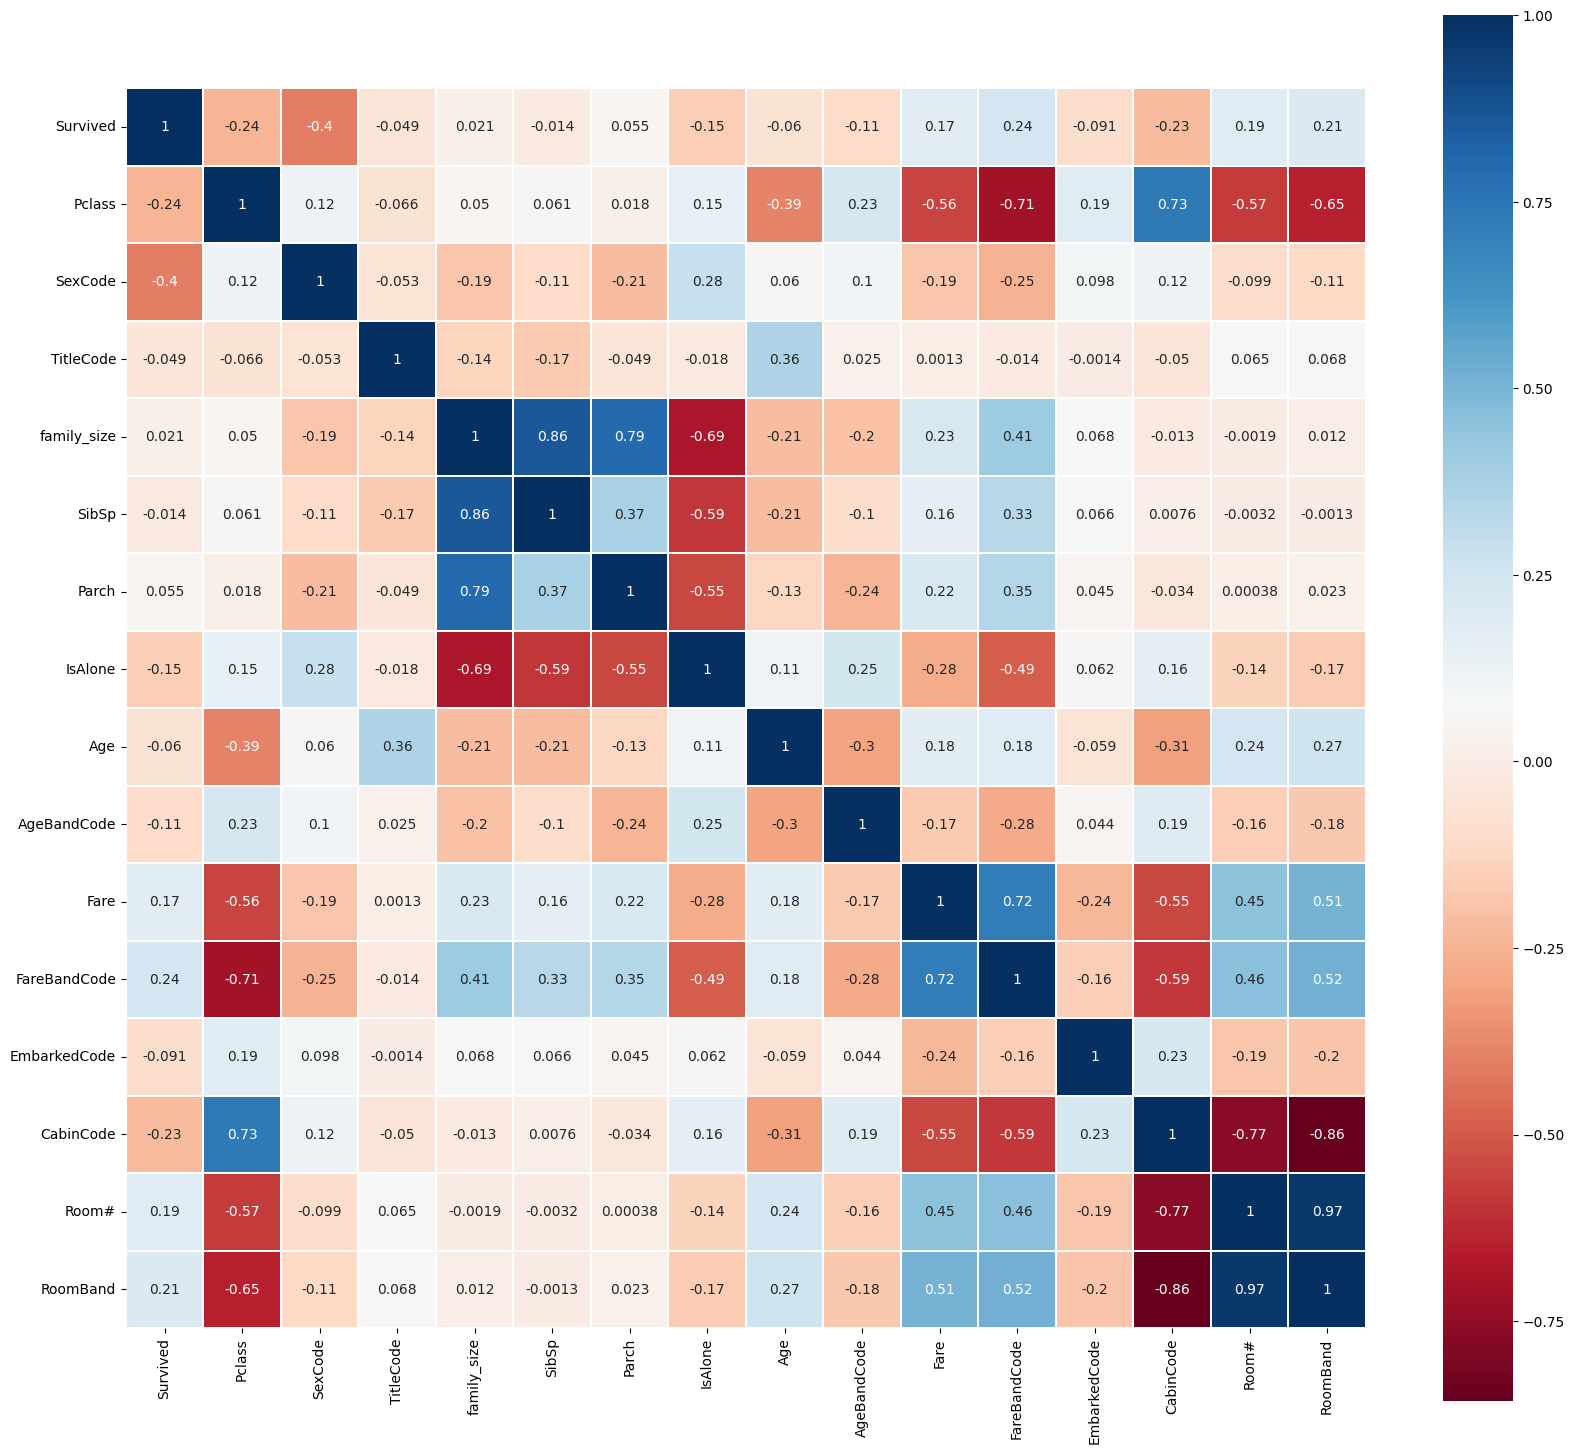

In [16]:
features = data[[
    'Survived',
    'Pclass',
    'SexCode',
    'TitleCode',
    'family_size',
    'SibSp',
    'Parch',
    'IsAlone',
    'Age',
    'AgeBandCode',
    'Fare',
    'FareBandCode',    
    'EmbarkedCode',
    'CabinCode',
    'Room#',
    'RoomBand',
]]
plt.figure(figsize=(20,18))
sns.heatmap(features.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=plt.cm.RdBu, annot=True)

## **Split the training data into features (X_train) and target (y_train) and selecting only relevant variables**

In [17]:
# Define the target variable name
target_column = 'Survived'
features = [
    'Pclass',
    'Sex',
    'Title',
    'family_size',
    'SibSp',
    'Parch',
    'IsAlone',
    #'Age',
    'AgeBand',
    'Fare',
    #'FareBand',    
    #'Embarked',
    'CabinCode',
    #'Room#',
    'RoomBand',
]

# Split the training data into features (X_train) and target (y_train)

# Droping inrelevant variables

X_train = data[:len(train_data)][features]
y_train = data[:len(train_data)][target_column]
X_test = data[len(train_data):][features]
    
# Verify the shapes of the datasets
print(X_train.shape, y_train.shape)

(891, 11) (891,)


**Convert categorical variable into dummy/indicator variables**

In [18]:
#Convert categorical variable into dummy/indicator variables
X_train['Pclass'] = X_train['Pclass'].astype(str)
X_train['IsAlone'] = X_train['IsAlone'].astype(str)
X_train['RoomBand'] = X_train['RoomBand'].astype(str)
X_train['CabinCode'] = X_train['CabinCode'].astype(str)
X_train['AgeBand'] = X_train['AgeBand'].astype(str)

temp = pd.get_dummies(X_train[['Sex','Title','Pclass','IsAlone','AgeBand','RoomBand','CabinCode']], drop_first = False)
X_train = pd.concat([X_train, temp], axis=1)
X_train.drop(['Sex','Title','Pclass','IsAlone','AgeBand','RoomBand','CabinCode'], axis=1, inplace=True)

X_test['Pclass'] = X_test['Pclass'].astype(str)
X_test['IsAlone'] = X_test['IsAlone'].astype(str)
X_test['RoomBand'] = X_test['RoomBand'].astype(str)
X_test['CabinCode'] = X_test['CabinCode'].astype(str)
X_test['AgeBand'] = X_test['AgeBand'].astype(str)

temp = pd.get_dummies(X_test[['Sex','Title','Pclass','IsAlone','AgeBand','RoomBand','CabinCode']], drop_first = False)
X_test = pd.concat([X_test, temp], axis=1)
X_test.drop(['Sex','Title','Pclass','IsAlone','AgeBand','RoomBand','CabinCode'], axis=1, inplace=True)

In [19]:
print(X_train.shape, y_train.shape, X_test.shape)

(891, 36) (891,) (418, 36)


In [20]:
# Encoding categorical variables
# Assuming categorical features are ['feature1', 'feature2', ...]
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = LabelEncoder().fit_transform(X_train[col])
    
for col in X_test.select_dtypes(include=['object']).columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col])
    
X_test.head()

,family_size,SibSp,Parch,Fare,Sex_female,Sex_male,Title_Honored,Title_Master,Title_Miss,Title_Mr,...,RoomBand_4.0,RoomBand_5.0,CabinCode_0,CabinCode_1,CabinCode_2,CabinCode_3,CabinCode_4,CabinCode_5,CabinCode_6,CabinCode_7
0,0.0,0.0,0.0,7.8292,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1.0,0.0,7.0000,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.0,0.0,0.0,9.6875,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0.0,0.0,0.0,8.6625,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,2.0,1.0,1.0,12.2875,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Part4: Train the model and submission

In [21]:
# Creating DMatrix for XGBoost

#train = xgb.DMatrix(X_train, label=y_train)
#test = xgb.DMatrix(X_test)

xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, gamma=2, learning_rate=0.3, max_delta_step=1,
       max_depth=4, min_child_weight=2, n_estimators=280,
       n_jobs=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)

xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)

print(predictions[:50])

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 1 1]
Your submission was successfully saved!
